# Create and run a local RAG pipeline from scratch

Follow along tutorial: https://www.youtube.com/watch?v=qN_2fnOPY-M

Features taught:
- Open a PDF document (use any pdf or a collection of pdfs).
- Format the text of the PDF ready for an embedding model.
- Build a retrieval syetm that uses vector search to find relevant chunck of text based on a query.
- Create a prompt that incorporates the retrieved pieces of text.
- Generate an answer to a query based on the passages of the textbook with an LLM.

## 1 - Document/text processing and embedding creation

Steps:
- Import document.
- Process text for embedding.
- Embed text chuncks with embedding model.
- Save embeddings to file for later.

### 1.1 PDF reading

In [1]:
import os
import requests

# Get PDF document path
pdf_path = "human-nutrition-text.pdf"

# Download PDF
if not os.path.exists(pdf_path):
    print(f"[INFO] File doesn't exist, downloading...")

    # Enter the url
    url = "https://pressbooks.oer.hawaii.edu/humannutrition2/open/download?type=pdf"

    # The local filename to save the file
    filename = pdf_path

    # Send a GET request to the URL
    response = requests.get(url)

    # Check if the request was successful
    if response.status_code == 200:
        # Open the file and save it
        with open(filename, "wb") as file:
            file.write(response.content)

        print(f"[INFO] The file has been downloaded and saved as {filename}")
    else:
        print(f"[INFO] Failed to download the file. Status code: {response.status_code}")

else:
    print(f"[INFO] File {pdf_path} exists.")

[INFO] File human-nutrition-text.pdf exists.


In [2]:
import fitz # PyMuPDF
from tqdm.auto import tqdm


def text_formatter(text: str) -> str:
    """Performs minor formatting on text."""
    cleaned_text = text.replace("\n", " ").strip()

    # More text formatting functions can go here
    return cleaned_text

def open_and_read_pdf(pdf_path: str) -> list[dict]:
    doc = fitz.open(pdf_path)
    pages_and_texts = []

    for page_number, page in tqdm(enumerate(doc)):
        text = page.get_text() # from fitz
        text = text_formatter(text=text)
        pages_and_texts.append({"page_number": page_number - 41,
                                "page_char_count": len(text),
                                "page_word_count": len(text.split(" ")),
                                "page_sentence_count_raw": len(text.split(". ")),
                                "page_token_count": len(text) / 4, # 1 token ~= 4 char
                                "text": text
                            })
        
    return pages_and_texts
    
pages_and_texts = open_and_read_pdf(pdf_path=pdf_path)
pages_and_texts[:2]

0it [00:00, ?it/s]

[{'page_number': -41,
  'page_char_count': 29,
  'page_word_count': 4,
  'page_sentence_count_raw': 1,
  'page_token_count': 7.25,
  'text': 'Human Nutrition: 2020 Edition'},
 {'page_number': -40,
  'page_char_count': 0,
  'page_word_count': 1,
  'page_sentence_count_raw': 1,
  'page_token_count': 0.0,
  'text': ''}]

In [3]:
import random

random.sample(pages_and_texts, k=3)

[{'page_number': 580,
  'page_char_count': 1072,
  'page_word_count': 202,
  'page_sentence_count_raw': 8,
  'page_token_count': 268.0,
  'text': 'Spina bifida  is a  neural-tube  defect that  can have  severe health  consequence s.  that higher folate intakes may cause colon cancer, however  scientific studies refute this hypothesis.  Figure 9.18 Spina Bifida in Infants  Dietary Reference Intakes  The RDAs and ULs for different age groups for folate are listed  in Table 9.25 “Dietary Reference Intakes for Folate “. Folate is a  compound that is found naturally in foods. Folic acid however is  the chemical structure form that is used in dietary supplements  as well as enriched foods such as grains. The FNB has developed  dietary folate equivalents (DFE) to reflect the fact that folic acid is  more bioavailable and easily absorbed than folate found in food. The  conversions for the different forms are listed below.  1 mcg DFE = 1 mcg food folate  1mcg DFE = 0.6 mcg folic acid from forti

In [4]:
import pandas as pd

df = pd.DataFrame(pages_and_texts)
df.head()

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,text
0,-41,29,4,1,7.25,Human Nutrition: 2020 Edition
1,-40,0,1,1,0.00,
2,-39,320,54,1,80.00,Human Nutrition: 2020 Edition UNIVERSITY OF ...
3,-38,212,32,1,53.00,Human Nutrition: 2020 Edition by University of...
4,-37,797,147,3,199.25,Contents Preface University of Hawai‘i at Mā...


In [5]:
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count
count,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.00,199.50,10.52,287.00
std,348.86,560.38,95.83,6.55,140.10
min,-41.00,0.00,1.00,1.00,0.00
25%,260.75,762.00,134.00,5.00,190.50
50%,562.50,1231.50,216.00,10.00,307.88
75%,864.25,1603.50,272.00,15.00,400.88
max,1166.00,2308.00,430.00,39.00,577.00


Token count is important to think about because:
- embedding models don't deal with infinite tokens.
- LLms don't deal with infinite tokens.

Embedding model may have been trained to embed sequences of 384 tokens into numerical space. (sentence-transformers).
For LLMs, they can't accept infinite token in their context window.

### 1.2 Chuncking

Done this with split(". ") earlier
Now using NLP library spaCy

In [6]:
from spacy.lang.en import English

nlp = English()

# Add a sentencizer pipeline -> Robust
nlp.add_pipe("sentencizer")

# Create document instance as an example
doc = nlp("This is a sentence. This is another sentence. I like elephants.")
assert len(list(doc.sents)) == 3

# Print out sentences split
list(doc.sents)

[This is a sentence., This is another sentence., I like elephants.]

In [7]:
pages_and_texts[600]

{'page_number': 559,
 'page_char_count': 863,
 'page_word_count': 138,
 'page_sentence_count_raw': 9,
 'page_token_count': 215.75,
 'text': 'Image by  Allison  Calabrese /  CC BY 4.0  Korsakoff syndrome can cause similar symptoms as beriberi such  as confusion, loss of coordination, vision changes, hallucinations,  and may progress to coma and death. This condition is specific  to alcoholics as diets high in alcohol can cause thiamin deficiency.  Other individuals at risk include individuals who also consume diets  typically low in micronutrients such as those with eating disorders,  elderly, and individuals who have gone through gastric bypass  surgery.5  Figure 9.10 The Role of Thiamin  Figure 9.11 Beriberi, Thiamin Deficiency  5. Fact Sheets for Health Professionals: Thiamin. National  Institute of Health, Office of Dietary Supplements.   https://ods.od.nih.gov/factsheets/Thiamin- HealthProfessional/. Updated Feburary 11, 2016.  Accessed October 22, 2017.  Water-Soluble Vitamins  | 

In [8]:
for item in tqdm(pages_and_texts):
    item['sentences'] = list(nlp(item["text"]).sents)

    # Make sure all sentences are strings (default type is spaCy datatype)
    item["sentences"] = [str(sentence) for sentence in item["sentences"]]

    # Count the sentences
    item["page_sentence_count_spacy"] = len(item["sentences"])

  0%|          | 0/1208 [00:00<?, ?it/s]

In [9]:
random.sample(pages_and_texts, k=1)

[{'page_number': 277,
  'page_char_count': 1924,
  'page_word_count': 318,
  'page_sentence_count_raw': 16,
  'page_token_count': 481.0,
  'text': 'often.  • Calm your “sweet tooth” by eating fruits, such as berries or an  apple.  • Replace sugary soft drinks with seltzer water, tea, or a small  amount of 100 percent fruit juice added to water or soda water.  The Food Industry: Functional Attributes of  Carbohydrates and the Use of Sugar Substitutes  In the food industry, both fast-releasing and slow-releasing  carbohydrates are utilized to give foods a wide spectrum of  functional attributes, including increased sweetness, viscosity, bulk,  coating ability, solubility, consistency, texture, body, and browning  capacity. The differences in chemical structure between the  different carbohydrates confer their varied functional uses in foods.  Starches, gums, and pectins are used as thickening agents in making  jam, cakes, cookies, noodles, canned products, imitation cheeses,  and a varie

In [10]:
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy
count,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.00,199.50,10.52,287.00,10.32
std,348.86,560.38,95.83,6.55,140.10,6.30
min,-41.00,0.00,1.00,1.00,0.00,0.00
25%,260.75,762.00,134.00,5.00,190.50,5.00
50%,562.50,1231.50,216.00,10.00,307.88,10.00
75%,864.25,1603.50,272.00,15.00,400.88,15.00
max,1166.00,2308.00,430.00,39.00,577.00,28.00


There are frameworks to get this done, but doing chunking with Python for now

In [11]:
# Define split size to turn groups of sentences into chuncks
num_sentence_chunk_size = 10

# Create a func to split lists of texts recursively into chunk size
# e.g. [20] -> [10, 10] or [25] -> [10,10,5]
def split_list(input_list: list[str],
               slice_size: int=num_sentence_chunk_size) -> list[list[str]]:
    return [input_list[i:i + slice_size] for i in range(0, len(input_list), slice_size)]

test_list = list(range(25))
split_list(test_list)

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [20, 21, 22, 23, 24]]

In [12]:
# Loop through pages and texts and split sentences into chunks
for item in tqdm(pages_and_texts):
    item["sentence_chunks"] = split_list(item["sentences"], slice_size=num_sentence_chunk_size)

    item["num_chunks"] = len(item["sentence_chunks"])

  0%|          | 0/1208 [00:00<?, ?it/s]

In [13]:
random.sample(pages_and_texts, k=1)

[{'page_number': 721,
  'page_char_count': 488,
  'page_word_count': 96,
  'page_sentence_count_raw': 5,
  'page_token_count': 122.0,
  'text': 'per day for a 2,000 kilocalories per day diet is 65 grams. Eighteen  percent of sixty-five equals about 12 grams. This means that 53  grams of fat are remaining in your fat allowance. Remember, to have  a healthy diet the recommendation is to eat less than this amount of  fat grams per day, especially if you want to lose weight.  Table 12.2 Updated DVs Based on a Caloric Intake of 2,000  Calories (For Adults and Children Four or More Years of Age)  Discovering Nutrition Facts  |  721',
  'sentences': ['per day for a 2,000 kilocalories per day diet is 65 grams.',
   'Eighteen  percent of sixty-five equals about 12 grams.',
   'This means that 53  grams of fat are remaining in your fat allowance.',
   'Remember, to have  a healthy diet the recommendation is to eat less than this amount of  fat grams per day, especially if you want to lose weight

In [14]:
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy,num_chunks
count,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.00,199.50,10.52,287.00,10.32,1.53
std,348.86,560.38,95.83,6.55,140.10,6.30,0.64
min,-41.00,0.00,1.00,1.00,0.00,0.00,0.00
25%,260.75,762.00,134.00,5.00,190.50,5.00,1.00
50%,562.50,1231.50,216.00,10.00,307.88,10.00,1.00
75%,864.25,1603.50,272.00,15.00,400.88,15.00,2.00
max,1166.00,2308.00,430.00,39.00,577.00,28.00,3.00


In [15]:
import re

# Split each chunk into its own item
pages_and_chunks = []
for item in tqdm(pages_and_texts):
    for sentence_chunk in item["sentence_chunks"]:
        chunk_dict = {}
        chunk_dict["page_number"] = item["page_number"]
        
        # Join the sentences together into paragraph-like structure, aka join the list of sentences into one paragraph
        joined_sentence_chunk = "".join(sentence_chunk).replace("  ", " ").strip()
        joined_sentence_chunk = re.sub(r'\.([A-Z]|[0-9])', r'. \1', joined_sentence_chunk) # ".A" => ". A"
        
        chunk_dict["sentence_chunk"] = joined_sentence_chunk

        # Get some stats on our chunks
        chunk_dict["chunk_char_count"] = len(joined_sentence_chunk)
        chunk_dict["chunk_word_count"] = len([word for word in joined_sentence_chunk.split(" ")])
        chunk_dict["chunk_token_count"] = len(joined_sentence_chunk) / 4

        pages_and_chunks.append(chunk_dict)

len(pages_and_chunks)

  0%|          | 0/1208 [00:00<?, ?it/s]

1843

In [16]:
random.sample(pages_and_chunks, k=1)

[{'page_number': 703,
  'sentence_chunk': 'An interactive or media element has been excluded from this version of the text. You can view it online here: http://pressbooks.oer.hawaii.edu/ humannutrition2/?p=404  An interactive or media element has been excluded from this version of the text. You can view it online here: http://pressbooks.oer.hawaii.edu/ humannutrition2/?p=404  An interactive or media element has been excluded from this version of the text. You can view it online here: http://pressbooks.oer.hawaii.edu/ humannutrition2/?p=404  Summary of Trace Minerals | 703',
  'chunk_char_count': 535,
  'chunk_word_count': 75,
  'chunk_token_count': 133.75}]

In [17]:
df = pd.DataFrame(pages_and_chunks)
df.describe().round(2)

,page_number,chunk_char_count,chunk_word_count,chunk_token_count
count,1843.00,1843.00,1843.00,1843.00
mean,583.38,735.15,113.80,183.79
std,347.79,447.98,71.79,112.00
min,-41.00,12.00,3.00,3.00
25%,280.50,315.50,45.00,78.88
50%,586.00,745.00,117.00,186.25
75%,890.00,1118.50,175.00,279.62
max,1166.00,1830.00,297.00,457.50


In [18]:
# Show random chunks with under 30 tokens in length
min_token_length = 30

for row in df[df["chunk_token_count"] <= min_token_length].sample(5).iterrows():
    print(f"Chunk token count: {row[1]["chunk_token_count"]} | Text: {row[1]["sentence_chunk"]}")

Chunk token count: 15.75 | Text: PART IV CHAPTER 4. CARBOHYDRATES Chapter 4. Carbohydrates | 227
Chunk token count: 10.25 | Text: Table 3. 6 Salt Alternatives 186 | Sodium
Chunk token count: 9.75 | Text: Older Adulthood: The Golden Years | 925
Chunk token count: 20.5 | Text: http://pressbooks.oer.hawaii.edu/ humannutrition2/?p=84  The Digestive System | 81
Chunk token count: 21.5 | Text: http://www.health.gov.fj/?page_id=1406. Accessed November 12, 2017. 652 | Introduction


We see smaller chunk don't contain relevant information

In [19]:
# Filter our Dataframe with rows under 30 tokens
pages_and_chunks_over_min_token_length = df[df["chunk_token_count"] > min_token_length].to_dict(orient="records")
pages_and_chunks_over_min_token_length[:2]

[{'page_number': -39,
  'sentence_chunk': 'Human Nutrition: 2020 Edition UNIVERSITY OF HAWAI‘I AT MĀNOA FOOD SCIENCE AND HUMAN NUTRITION PROGRAM ALAN TITCHENAL, SKYLAR HARA, NOEMI ARCEO CAACBAY, WILLIAM MEINKE-LAU, YA-YUN YANG, MARIE KAINOA FIALKOWSKI REVILLA, JENNIFER DRAPER, GEMADY LANGFELDER, CHERYL GIBBY, CHYNA NICOLE CHUN, AND ALLISON CALABRESE',
  'chunk_char_count': 308,
  'chunk_word_count': 42,
  'chunk_token_count': 77.0},
 {'page_number': -38,
  'sentence_chunk': 'Human Nutrition: 2020 Edition by University of Hawai‘i at Mānoa Food Science and Human Nutrition Program is licensed under a Creative Commons Attribution 4. 0 International License, except where otherwise noted.',
  'chunk_char_count': 211,
  'chunk_word_count': 31,
  'chunk_token_count': 52.75}]

In [20]:
random.sample(pages_and_chunks_over_min_token_length, k=1)

[{'page_number': 1141,
  'sentence_chunk': 'program dedicated to addressing the nutritional needs of senior citizens. Each day, Meals on Wheels volunteers deliver more than one million meals across the United States. The first Meals on Wheels program began in Philadelphia in the 1950s. In the decades since, the organization has expanded into a vast network that serves the elderly in all fifty states and several US territories. Today, Meals on Wheels remains committed to ending hunger among the senior citizen community. 15 Nutrition and Your Health The adage, “you are what you eat,” seems to be more true today than ever. In recent years, consumers have become more conscientious about the decisions they make in the supermarket. Organically grown food is the fastest growing segment of the food industry. Also, farmers’ markets and chains that are health-food-oriented are thriving in many parts of North America. Shoppers have begun to pay more attention to the effect of food on their health

### 1.3 Embedding chunks

In [21]:
from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2", device="mps")

# Create a list of sentences
sentences = ["This is a test for a first sentence to try all this out.", "Wow this one should be the shortest one.", "We are trying to capture the meaning in these sentences"]

# Sentences are encoded/embeded by calling model.encode()
embeddings = embedding_model.encode(sentences)
embeddings_dict = dict(zip(sentences, embeddings))

# See the embeddings
for sentence, embedding in embeddings_dict.items():
    print(f"Sentence: {sentence}")
    print(f"Embedding: {embedding}")
    print()

/Users/thomas/repos/imperial/project/ms-project/projectenv/lib/python3.12/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/Users/thomas/repos/imperial/project/ms-project/projectenv/lib/python3.12/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Sentence: This is a test for a first sentence to try all this out.
Embedding: [ 2.85356194e-02 -3.35751325e-02 -2.30838126e-03 -5.84920719e-02
 -1.70859955e-02  3.01622916e-02  5.22479834e-03  4.90843467e-02
  1.12240473e-02 -1.22965744e-03  4.59204204e-02 -3.62499654e-02
  1.02915447e-02 -5.38161285e-02  6.83766529e-02 -3.79931144e-02
  3.71249095e-02 -7.90195446e-03 -8.98051169e-03  3.71554531e-02
 -9.70261265e-03  2.40376312e-02  1.41921537e-02  5.59353177e-03
 -3.14894170e-02  1.87178608e-03 -4.31228280e-02  1.35444310e-02
 -2.70622130e-02 -7.03717545e-02  2.94639133e-02 -5.87432971e-03
  5.48386760e-03 -5.58810793e-02  2.08344204e-06 -6.47310959e-03
 -7.72892125e-03 -2.59932801e-02 -3.00901830e-02 -6.77412655e-03
  3.72368358e-02  5.80941178e-02  3.78317647e-02  7.31440708e-02
  4.50658519e-03 -7.87458755e-03  3.45539115e-02 -6.41292520e-03
 -1.01021737e-01  6.83228597e-02 -2.02434720e-03 -7.68904062e-03
 -4.05383259e-02 -5.95648251e-02  8.64745677e-02  4.26733755e-02
  1.50622483

In [22]:
embeddings[0].shape

(768,)

In [23]:
embedding = embedding_model.encode("My favorite fruit is the apple")
print(embedding)

[-1.42266825e-02  2.72105131e-02 -2.95058284e-02  6.79802010e-03
  2.45159082e-02  1.33510362e-02 -7.62987733e-02 -1.10062556e-02
  3.71713080e-02  2.92971767e-02  1.38442451e-02  2.53697615e-02
 -2.89815478e-02 -4.02019881e-02 -4.13757078e-02 -1.42179606e-02
  1.38140051e-02  3.32536548e-02  1.91554450e-03  1.83311142e-02
 -6.05194047e-02  5.59520870e-02 -8.91377125e-03  4.32403199e-03
 -3.66971195e-02  2.19621863e-02 -1.54881841e-02 -2.42264383e-02
  2.05872059e-02  2.63434183e-03 -6.93415031e-02 -1.35526033e-02
 -7.34304637e-02 -9.59714595e-03  1.32204343e-06 -2.03906242e-02
  2.74591744e-02  3.10231559e-02 -5.04907593e-02  1.76010337e-02
 -1.28882071e-02  4.13835980e-02 -3.13813165e-02  1.60297249e-02
 -4.47294936e-02  1.81994811e-02  9.94089060e-03  1.55189401e-03
 -3.46055292e-02  5.07480726e-02 -8.52690451e-03 -4.99984585e-02
  9.65030026e-03 -6.84350356e-03 -3.79929282e-02  5.99238686e-02
  6.85515255e-02 -2.54973746e-03  5.14408052e-02  3.77722867e-02
  1.60276075e-03 -9.80131

In [24]:
%%time

# embedding_model.to("cpu")

# Embed each chunk one by one
# for item in tqdm(pages_and_chunks_over_min_token_length):
#     item["embedding"] = embedding_model.encode(item["sentence_chunk"])


embedding_model.to("mps") # Not working, seems this library doesn't support mps

for item in tqdm(pages_and_chunks_over_min_token_length):
    item["embedding"] = embedding_model.encode(item["sentence_chunk"])

  0%|          | 0/1680 [00:00<?, ?it/s]

CPU times: user 1min 9s, sys: 11.3 s, total: 1min 21s
Wall time: 1min 22s


In [25]:
%%time

text_chunks = [item["sentence_chunk"] for item in pages_and_chunks_over_min_token_length]
text_chunks[419]

CPU times: user 137 μs, sys: 16 μs, total: 153 μs
Wall time: 156 μs


'often. • Calm your “sweet tooth” by eating fruits, such as berries or an apple. • Replace sugary soft drinks with seltzer water, tea, or a small amount of 100 percent fruit juice added to water or soda water. The Food Industry: Functional Attributes of Carbohydrates and the Use of Sugar Substitutes In the food industry, both fast-releasing and slow-releasing carbohydrates are utilized to give foods a wide spectrum of functional attributes, including increased sweetness, viscosity, bulk, coating ability, solubility, consistency, texture, body, and browning capacity. The differences in chemical structure between the different carbohydrates confer their varied functional uses in foods. Starches, gums, and pectins are used as thickening agents in making jam, cakes, cookies, noodles, canned products, imitation cheeses, and a variety of other foods. Molecular gastronomists use slow- releasing carbohydrates, such as alginate, to give shape and texture to their fascinating food creations. Add

In [26]:
len(text_chunks)

1680

In [27]:
%%time

# Embed all texts in batches
text_chunk_embeddings = embedding_model.encode(text_chunks, batch_size=32, convert_to_tensor=True)

text_chunk_embeddings

CPU times: user 10.4 s, sys: 1.59 s, total: 12 s
Wall time: 18 s


tensor([[ 0.0674,  0.0902, -0.0051,  ..., -0.0221, -0.0232,  0.0126],
        [ 0.0552,  0.0592, -0.0166,  ..., -0.0120, -0.0103,  0.0227],
        [ 0.0280,  0.0340, -0.0206,  ..., -0.0054,  0.0213,  0.0313],
        ...,
        [ 0.0771,  0.0098, -0.0122,  ..., -0.0409, -0.0752, -0.0241],
        [ 0.1030, -0.0165,  0.0083,  ..., -0.0574, -0.0283, -0.0295],
        [ 0.0864, -0.0125, -0.0113,  ..., -0.0522, -0.0337, -0.0299]],
       device='mps:0')

### 1.4 Save embeddings

In [28]:
pages_and_chunks_over_min_token_length[419]

{'page_number': 277,
 'sentence_chunk': 'often. • Calm your “sweet tooth” by eating fruits, such as berries or an apple. • Replace sugary soft drinks with seltzer water, tea, or a small amount of 100 percent fruit juice added to water or soda water. The Food Industry: Functional Attributes of Carbohydrates and the Use of Sugar Substitutes In the food industry, both fast-releasing and slow-releasing carbohydrates are utilized to give foods a wide spectrum of functional attributes, including increased sweetness, viscosity, bulk, coating ability, solubility, consistency, texture, body, and browning capacity. The differences in chemical structure between the different carbohydrates confer their varied functional uses in foods. Starches, gums, and pectins are used as thickening agents in making jam, cakes, cookies, noodles, canned products, imitation cheeses, and a variety of other foods. Molecular gastronomists use slow- releasing carbohydrates, such as alginate, to give shape and texture 

In [29]:
# Save embeddings to file
text_chunks_and_embeddings_df = pd.DataFrame(pages_and_chunks_over_min_token_length)
embeddings_df_save_path = "text_chunks_and_embeddings_df.csv"
text_chunks_and_embeddings_df.to_csv(embeddings_df_save_path, index=False)

In [30]:
# Import saved file and view
text_chunks_and_embeddings_df_load = pd.read_csv(embeddings_df_save_path)
text_chunks_and_embeddings_df_load.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-39,Human Nutrition: 2020 Edition UNIVERSITY OF HA...,308,42,77.00,[ 6.74242601e-02 9.02282670e-02 -5.09549258e-...
1,-38,Human Nutrition: 2020 Edition by University of...,211,31,52.75,[ 5.52156046e-02 5.92140071e-02 -1.66167393e-...
2,-37,Contents Preface University of Hawai‘i at Māno...,766,116,191.50,[ 2.79801879e-02 3.39814052e-02 -2.06426717e-...
3,-36,Lifestyles and Nutrition University of Hawai‘i...,941,144,235.25,[ 6.82566687e-02 3.81275490e-02 -8.46851896e-...
4,-35,The Cardiovascular System University of Hawai‘...,998,152,249.50,[ 3.30264233e-02 -8.49767867e-03 9.57161840e-...


If the database is large, this is when to look into vector db to store these information for fast retrieval

## 2 - Search and answer

### 2.1 Search

In [31]:
import random

import torch
import numpy as np
import pandas as pd

device = "mps" if torch.mps.is_available() else "cpu"

# Import texts and embedding df
text_chunks_and_embeddings_df = pd.read_csv("text_chunks_and_embeddings_df.csv")

# Convert embedding column back into np.array (it got converted to string when saved to csv)
text_chunks_and_embeddings_df["embedding"] = text_chunks_and_embeddings_df["embedding"].apply(lambda x: np.fromstring(x.strip("[]"), sep=" "))

# Convert to a torch.tensor
embeddings = torch.tensor(np.stack(text_chunks_and_embeddings_df["embedding"].tolist(), axis=0), dtype=torch.float32).to(device)

# Convert texts and embedding df to list of dicts
pages_and_chunks = text_chunks_and_embeddings_df.to_dict(orient="records")

text_chunks_and_embeddings_df

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-39,Human Nutrition: 2020 Edition UNIVERSITY OF HA...,308,42,77.00,"[0.0674242601, 0.090228267, -0.00509549258, -0..."
1,-38,Human Nutrition: 2020 Edition by University of...,211,31,52.75,"[0.0552156046, 0.0592140071, -0.0166167393, -0..."
2,-37,Contents Preface University of Hawai‘i at Māno...,766,116,191.50,"[0.0279801879, 0.0339814052, -0.0206426717, 0...."
3,-36,Lifestyles and Nutrition University of Hawai‘i...,941,144,235.25,"[0.0682566687, 0.038127549, -0.00846851896, -0..."
4,-35,The Cardiovascular System University of Hawai‘...,998,152,249.50,"[0.0330264233, -0.00849767867, 0.0095716184, -..."
...,...,...,...,...,...,...
1675,1164,Flashcard Images Note: Most images in the flas...,1306,188,326.50,"[0.0185622573, -0.0164277367, -0.0127045764, -..."
1676,1164,Hazard Analysis Critical Control Points reused...,374,51,93.50,"[0.0334720686, -0.0570440441, 0.0151489535, -0..."
1677,1165,ShareAlike 11. Organs reused “Pancreas Organ A...,1287,177,321.75,"[0.0770515352, 0.00978556834, -0.0121817328, 0..."
1678,1165,Sucrose reused “Figure 03 02 05” by OpenStax B...,410,63,102.50,"[0.103045143, -0.0164701864, 0.00826846622, 0...."


In [32]:
embeddings.shape

torch.Size([1680, 768])

In [33]:
# Create embedding model -> Already done in first section
from sentence_transformers import util, SentenceTransformer

embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2", device=device)

/Users/thomas/repos/imperial/project/ms-project/projectenv/lib/python3.12/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Create small semantic search pipeline
- Define a query string.
- Turn the query into an embedding.
- Perform a dot product or cosine similarity function between the text embeddings and the query embedding.
- Sort the results from 3 in descending order.


In [34]:
# Define a query
query = "macronutrient functions"
print(f"Query : {query}")

# Embed the query -> Important to embed it with the same model used for the text embeddings
query_embedding = embedding_model.encode(query, convert_to_tensor=True).to(device)

# Get similarity scores with the dot product (use cosine similarity if outputs of model aren't normalized)
from time import perf_counter as timer

start_time = timer()
dot_scores = util.dot_score(a=query_embedding, b=embeddings)[0]
end_time = timer()

print(f"[INFO] Time taken to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

# Get the top-k results (top 5)
top_results_dot_product = torch.topk(dot_scores, k=5)
top_results_dot_product

Query : macronutrient functions
[INFO] Time taken to get scores on 1680 embeddings: 0.00936 seconds.


torch.return_types.topk(
values=tensor([0.6843, 0.6717, 0.6517, 0.6493, 0.6478], device='mps:0'),
indices=tensor([42, 47, 46, 51, 41], device='mps:0'))

In [35]:
pages_and_chunks[42]

{'page_number': 5,
 'sentence_chunk': 'Macronutrients Nutrients that are needed in large amounts are called macronutrients. There are three classes of macronutrients: carbohydrates, lipids, and proteins. These can be metabolically processed into cellular energy. The energy from macronutrients comes from their chemical bonds. This chemical energy is converted into cellular energy that is then utilized to perform work, allowing our bodies to conduct their basic functions. A unit of measurement of food energy is the calorie. On nutrition food labels the amount given for “calories” is actually equivalent to each calorie multiplied by one thousand. A kilocalorie (one thousand calories, denoted with a small “c”) is synonymous with the “Calorie” (with a capital “C”) on nutrition food labels. Water is also a macronutrient in the sense that you require a large amount of it, but unlike the other macronutrients, it does not yield calories. Carbohydrates Carbohydrates are molecules composed of car

In [36]:
large_embeddings = torch.randn(1000*embeddings.shape[0], 768).to(device)
print(f"Embeddings shape: {large_embeddings.shape}")

# Perform dot product accross 1,680,000 embeddings ~ 400+ bible worth of texts
start_time = timer()
dot_scores = util.dot_score(a=query_embedding, b=large_embeddings)[0]
end_time = timer()

print(f"[INFO] Time taken to get scores on {len(large_embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

Embeddings shape: torch.Size([1680000, 768])
[INFO] Time taken to get scores on 1680000 embeddings: 0.12866 seconds.


Searching over embeddings is very fast, but over 10M+ embeddings, it's probably better to taylor the search rather than going through all the embeddings
An index helps to narrow the retrieval. Popular indexing library is FAISS

In [37]:
import textwrap

def print_wrapped(text, wrap_length=80):
    wrapped_text = textwrap.fill(text, wrap_length)
    print(wrapped_text)

In [38]:
print(f"Query: '{query}'\n")
print("Results:")
# Loop through zipped together scores and indices from torch.topk
for score, idx in zip(top_results_dot_product[0], top_results_dot_product[1]):
    print(f"Score: {score:.4f}")
    print("Text:")
    print_wrapped(pages_and_chunks[idx]["sentence_chunk"])
    print(f"Page number: {pages_and_chunks[idx]['page_number']}")
    print("\n")

Query: 'macronutrient functions'

Results:
Score: 0.6843
Text:
Macronutrients Nutrients that are needed in large amounts are called
macronutrients. There are three classes of macronutrients: carbohydrates,
lipids, and proteins. These can be metabolically processed into cellular energy.
The energy from macronutrients comes from their chemical bonds. This chemical
energy is converted into cellular energy that is then utilized to perform work,
allowing our bodies to conduct their basic functions. A unit of measurement of
food energy is the calorie. On nutrition food labels the amount given for
“calories” is actually equivalent to each calorie multiplied by one thousand. A
kilocalorie (one thousand calories, denoted with a small “c”) is synonymous with
the “Calorie” (with a capital “C”) on nutrition food labels. Water is also a
macronutrient in the sense that you require a large amount of it, but unlike the
other macronutrients, it does not yield calories. Carbohydrates Carbohydrates
are m

We could improve the order of these results with a reranking model.

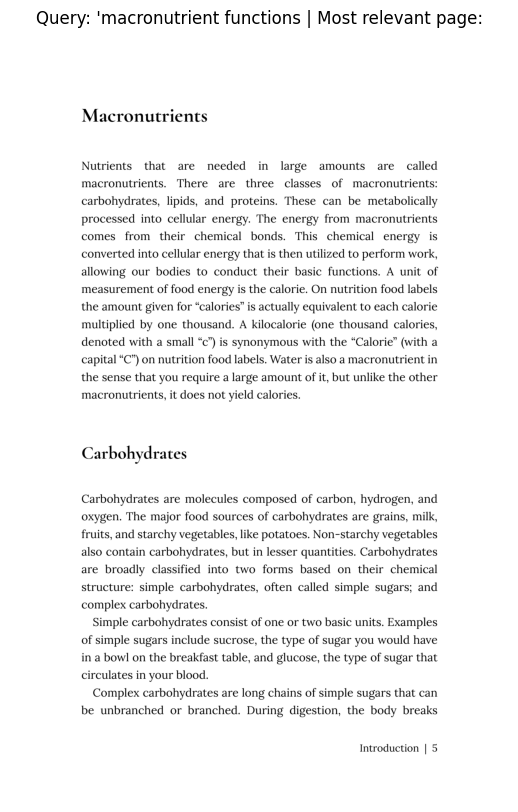

In [39]:
import fitz

# Open PDF and load the target
pdf_path = "human-nutrition-text.pdf"
doc = fitz.open(pdf_path)
page = doc.load_page(5+41) # pages_and_chunks[idx]['page_number'] + 41

# Get the image of the page
img = page.get_pixmap(dpi=300)

img_array = np.frombuffer(img.samples_mv, dtype=np.uint8).reshape(img.h, img.w, img.n)

# Display the image using matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(13, 10))
plt.imshow(img_array)
plt.title(f"Query: '{query} | Most relevant page:")
plt.axis("off")
plt.show()

### 2.2 Similarity measures

In [40]:
import torch

def dot_product(vector1, vector2):
    return torch.dot(vector1, vector2)

def cosine_similarity(vector1, vector2):
    dot_prod = dot_product(vector1, vector2)

    # Get Euclidean/L2 Norm
    norm_vector1 = torch.sqrt(torch.sum(vector1**2))
    norm_vector2 = torch.sqrt(torch.sum(vector2**2))

    return dot_prod / (norm_vector1 * norm_vector2)

In [41]:
# Example tensors
vector1 = torch.tensor([1,2,3], dtype=torch.float32)
vector2 = torch.tensor([1,2,3], dtype=torch.float32)
vector3 = torch.tensor([4,5,6], dtype=torch.float32)
vector4 = torch.tensor([-1,-2,-3], dtype=torch.float32)

# Calculate dot product
print("Dot product between vector1 and vector2: ", dot_product(vector1, vector2))
print("Dot product between vector1 and vector3: ", dot_product(vector1, vector3))
print("Dot product between vector1 and vector4: ", dot_product(vector1, vector4))

print()

# Cosine similarity normalizes the magnitude
print("Cosine similarity between vector1 and vector2: ", cosine_similarity(vector1, vector2))
print("Cosine similarity between vector1 and vector3: ", cosine_similarity(vector1, vector3))
print("Cosine similarity between vector1 and vector4: ", cosine_similarity(vector1, vector4))

Dot product between vector1 and vector2:  tensor(14.)
Dot product between vector1 and vector3:  tensor(32.)
Dot product between vector1 and vector4:  tensor(-14.)

Cosine similarity between vector1 and vector2:  tensor(1.0000)
Cosine similarity between vector1 and vector3:  tensor(0.9746)
Cosine similarity between vector1 and vector4:  tensor(-1.0000)


Based on how you encode the embeddings, they might already be normalized, hence dot product reduce unnecessary additional compute

### 2.3 Functionizing the semantic search pipeline

In [42]:
def retrieve_relevant_resources(query: str,
                                embeddings: torch.tensor,
                                model: SentenceTransformer=embedding_model,
                                n_resources_to_return: int=5,
                                print_time: bool=True
                            ):
    """Embeds a query with a model and returns top k scores and indices from embeddings"""

    # Embed the query
    query_embedding = model.encode(query, convert_to_tensor=True)

    # Get the dot product scores on embeddings
    start_time = timer()
    dot_scores = util.dot_score(query_embedding, embeddings)[0]
    end_time = timer()

    if print_time:
        print(f"[INFO] Time taken to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

    scores, indices = torch.topk(input=dot_scores, k=n_resources_to_return)

    return scores, indices

def print_top_results_and_scores(query: str,
                                 embeddings: torch.tensor,
                                 pages_and_chunks: list[dict]=pages_and_chunks,
                                 n_resources_to_return: int=5
                                ):
    """Finds relevant passages given a query and prints them out along with their scores"""
    scores, indices = retrieve_relevant_resources(query=query,
                                                  embeddings=embeddings,
                                                  n_resources_to_return=n_resources_to_return
                                                )
    
    # Loop through zipped together scores and indices from torch.topk
    for score, idx in zip(scores, indices):
        print(f"Score: {score:.4f}")
        print("Text:")
        print_wrapped(pages_and_chunks[idx]["sentence_chunk"])
        print(f"Page number: {pages_and_chunks[idx]['page_number']}")
        print("\n")
    

In [43]:
query="foods high in fiber"

# retrieve_relevant_resources(query=query, embeddings=embeddings)
print_top_results_and_scores(query=query, embeddings=embeddings)

[INFO] Time taken to get scores on 1680 embeddings: 0.00015 seconds.
Score: 0.6964
Text:
• Change it up a bit and experience the taste and satisfaction of other whole
grains such as barley, quinoa, and bulgur. • Eat snacks high in fiber, such as
almonds, pistachios, raisins, and air-popped popcorn. Add an artichoke and green
peas to your dinner plate more 276 | Carbohydrates and Personal Diet Choices
Page number: 276


Score: 0.6810
Text:
Dietary fiber is categorized as either water-soluble or insoluble. Some examples
of soluble fibers are inulin, pectin, and guar gum and they are found in peas,
beans, oats, barley, and rye. Cellulose and lignin are insoluble fibers and a
few dietary sources of them are whole-grain foods, flax, cauliflower, and
avocados. Cellulose is the most abundant fiber in plants, making up the cell
walls and providing structure. Soluble fibers are more easily accessible to
bacterial enzymes in the large intestine so they can be broken down to a greater
extent than

## 3 - Run LLM locally

### 3.1 Setup LLM

In [44]:
# Get GPU available memory
import torch

bytes_to_gb = 1000000000

current_allocated_memory = torch.mps.current_allocated_memory()
driver_allocated_memory = torch.mps.driver_allocated_memory()
recommended_max_memory = torch.mps.recommended_max_memory()

print(f"GPU Info:\nCurrent Allocated Memory: {current_allocated_memory/bytes_to_gb:.3f} GB\nDriver Allocated Memory: {driver_allocated_memory/bytes_to_gb:.3f} GB\nRecommended Max Memory: {recommended_max_memory/bytes_to_gb:.3f} GB")

GPU Info:
Current Allocated Memory: 6.152 GB
Driver Allocated Memory: 9.518 GB
Recommended Max Memory: 22.907 GB


In [46]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

# from transformers import BitsAndBytesConfig
# Quantization configs
# quantization_config = BitsAndBytesConfig(load_in_4bit=True,
#                                          bnb_4bit_compute_dtype=torch.float16
#                                         )
model_id = "google/gemma-2b-it"
attn_implementation = "sdpa" # Scaled dot product attention

# Note: flash attention 2 = faster atttention mechanism -> Check once access to nvidia GPUs

tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=model_id)

# Instantiate the model
llm_model = AutoModelForCausalLM.from_pretrained(pretrained_model_name_or_path=model_id,
                                                 torch_dtype=torch.float16,
                                                 quantization_config=None,
                                                 low_cpu_mem_usage=False,
                                                 attn_implementation=attn_implementation
                                                )

llm_model.to(device)

tokenizer_config.json:   0%|          | 0.00/34.2k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/627 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/13.5k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/67.1M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

GemmaForCausalLM(
  (model): GemmaModel(
    (embed_tokens): Embedding(256000, 2048, padding_idx=0)
    (layers): ModuleList(
      (0-17): 18 x GemmaDecoderLayer(
        (self_attn): GemmaSdpaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=256, bias=False)
          (v_proj): Linear(in_features=2048, out_features=256, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): GemmaRotaryEmbedding()
        )
        (mlp): GemmaMLP(
          (gate_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (up_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (down_proj): Linear(in_features=16384, out_features=2048, bias=False)
          (act_fn): GELUActivation()
        )
        (input_layernorm): GemmaRMSNorm()
        (post_attention_layernorm): GemmaRMSNorm()
      )
    )
    (norm): GemmaRM

In [47]:
def get_model_num_params(model: torch.nn.Module):
    return sum([param.numel() for param in model.parameters()])

get_model_num_params(llm_model)

2506172416

In [50]:
def get_model_mem_size(model: torch.nn.Module):
    # Get model parameters and buffer sizes
    mem_params = sum([param.nelement() * param.element_size() for param in model.parameters()])
    mem_buffers = sum([buf.nelement() * buf.element_size() for buf in model.buffers()])

    # Calculate model sizes
    model_mem_bytes = mem_params + mem_buffers
    model_mem_mb = model_mem_bytes / (1024**2)
    model_mem_gb = model_mem_bytes / (1024**3)

    return {"model_mem_bytes": round(model_mem_bytes, 2),
            "model_mem_mb": round(model_mem_mb, 2),
            "model_mem_gb": round(model_mem_gb, 2)
        }

get_model_mem_size(llm_model)

{'model_mem_bytes': 5079453696, 'model_mem_mb': 4844.14, 'model_mem_gb': 4.73}

### 3.2 Generate text with LLM